<a href="https://colab.research.google.com/github/Vishnutha/ML_Project/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastHeal Malware Prediction

##Importing required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn import preprocessing

In [ ]:
from numpy import *
import math
import pandas as pd
import matplotlib as plt
from google.colab import files
import dask
import dask.dataframe as dd
import warnings
import numpy as np
import gc
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

##Reading train and test data from google drive

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1qOwvhFXPkbd9yRYcNqdMkrTMVGfruZnj'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('train.csv')

In [ ]:
train_df  = pd.read_csv("train.csv",low_memory = False)

In [ ]:
file_id2 = '14tlnGaRrcrEAY4u5xPSJgMSgW7_fUn8e'
download2 = drive.CreateFile({'id': file_id2})
download2.GetContentFile('test.csv')
test_df = pd.read_csv("test.csv",low_memory = False)
test_df.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6123525,6123525,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1429.0,0,7.0,0,NaN,...,512.0,63175.0,0,0.0,0.0,0,0,0.0,0.0,1.0
1,6557910,6557910,win8defender,1.1.15100.1,4.9.10586.672,1.273.995.0,0,7.0,0,NaN,...,355.0,19951.0,0,0.0,0.0,0,0,0.0,0.0,11.0
2,2134897,2134897,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1730.0,0,7.0,0,NaN,...,355.0,7426.0,1,NaN,0.0,0,0,0.0,0.0,11.0
3,3368859,3368859,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,NaN,...,677.0,8156.0,1,NaN,0.0,1,1,1.0,0.0,15.0
4,3354858,3354858,win8defender,1.1.15200.1,4.18.1807.18075,1.275.876.0,0,7.0,0,NaN,...,142.0,41834.0,1,0.0,0.0,0,0,0.0,0.0,7.0


In [ ]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


Garbage collector

In [ ]:
gc.collect()

516

In [ ]:
test_df.head()

,Unnamed: 0,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
0,6123525,6123525,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1429.0,0,7.0,0,NaN,...,512.0,63175.0,0,0.0,0.0,0,0,0.0,0.0,1.0
1,6557910,6557910,win8defender,1.1.15100.1,4.9.10586.672,1.273.995.0,0,7.0,0,NaN,...,355.0,19951.0,0,0.0,0.0,0,0,0.0,0.0,11.0
2,2134897,2134897,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1730.0,0,7.0,0,NaN,...,355.0,7426.0,1,NaN,0.0,0,0,0.0,0.0,11.0
3,3368859,3368859,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1552.0,0,7.0,0,NaN,...,677.0,8156.0,1,NaN,0.0,1,1,1.0,0.0,15.0
4,3354858,3354858,win8defender,1.1.15200.1,4.18.1807.18075,1.275.876.0,0,7.0,0,NaN,...,142.0,41834.0,1,0.0,0.0,0,0,0.0,0.0,7.0


In [ ]:
train_df.describe()

,Unnamed: 0,MachineIdentifier,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,1.427437e+06,1.427437e+06,1.427437e+06,1.422280e+06,1.427437e+06,69034.000000,1.421542e+06,1.421542e+06,1.421542e+06,1.427437e+06,...,1.401853e+06,1.427437e+06,521212.0,1.424803e+06,1.427437e+06,1.427437e+06,1.416211e+06,1.378774e+06,1.378774e+06,1.427437e+06
mean,4.464695e+06,4.464695e+06,5.604450e-06,6.844938e+00,1.737730e-02,1660.099183,4.784247e+04,1.326524e+00,1.020875e+00,9.880177e-01,...,3.303730e+04,4.857566e-01,0.0,7.161692e-03,1.251908e-01,3.812357e-02,5.763336e-02,2.836281e-01,7.879336e+00,4.997930e-01
std,2.575295e+06,2.575295e+06,2.367366e-03,1.027449e+00,1.306726e-01,1002.946790,1.402022e+04,5.226712e-01,1.668508e-01,1.088060e-01,...,2.120403e+04,4.997973e-01,0.0,8.432323e-02,3.309353e-01,1.914946e-01,2.330489e-01,4.507586e-01,4.549816e+00,5.000001e-01
min,8.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,2.100000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.237167e+06,2.237167e+06,0.000000e+00,7.000000e+00,0.000000e+00,788.000000,4.948000e+04,1.000000e+00,1.000000e+00,1.000000e+00,...,1.315600e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,4.465422e+06,4.465422e+06,0.000000e+00,7.000000e+00,0.000000e+00,1632.000000,5.344700e+04,1.000000e+00,1.000000e+00,1.000000e+00,...,3.307000e+04,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00
75%,6.693923e+06,6.693923e+06,0.000000e+00,7.000000e+00,0.000000e+00,2388.000000,5.344700e+04,2.000000e+00,1.000000e+00,1.000000e+00,...,5.243100e+04,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00
max,8.921475e+06,8.921475e+06,1.000000e+00,3.500000e+01,1.000000e+00,3212.000000,7.049600e+04,6.000000e+00,5.000000e+00,1.000000e+00,...,7.209100e+04,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01,1.000000e+00


In [ ]:
test_df.describe()

,Unnamed: 0,MachineIdentifier,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier
count,3.568600e+05,3.568600e+05,356860.000000,355574.000000,356860.000000,17115.000000,355404.000000,355404.000000,355404.000000,356860.000000,...,349600.000000,350575.000000,356860.000000,130475.0,356220.000000,356860.000000,356860.000000,354121.000000,344981.000000,344981.000000
mean,4.462473e+06,4.462473e+06,0.000008,6.845796,0.017242,1664.970377,47846.552844,1.327050,1.021046,0.987774,...,403.335049,33028.774981,0.486746,0.0,0.006751,0.126307,0.038231,0.057754,0.283975,7.875451
std,2.577301e+06,2.577301e+06,0.002899,1.023361,0.130172,997.318238,14028.907701,0.523197,0.167494,0.109894,...,221.321883,21227.763102,0.499825,0.0,0.081889,0.332196,0.191753,0.233279,0.450926,4.548999
min,2.100000e+01,2.100000e+01,0.000000,0.000000,0.000000,1.000000,16.000000,1.000000,0.000000,0.000000,...,11.000000,12.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.229263e+06,2.229263e+06,0.000000,7.000000,0.000000,788.000000,49480.000000,1.000000,1.000000,1.000000,...,142.000000,13154.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,4.459479e+06,4.459479e+06,0.000000,7.000000,0.000000,1632.000000,53447.000000,1.000000,1.000000,1.000000,...,500.000000,33066.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,6.695464e+06,6.695464e+06,0.000000,7.000000,0.000000,2388.000000,53447.000000,2.000000,1.000000,1.000000,...,556.000000,52436.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000
max,8.921456e+06,8.921456e+06,1.000000,8.000000,1.000000,3196.000000,70492.000000,6.000000,5.000000,1.000000,...,1087.000000,72096.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000


# Preprocessing and Exploratory Data Analysis (EDA)

Histograms for Has Detections which shows how many 0s and 1s are there in the column

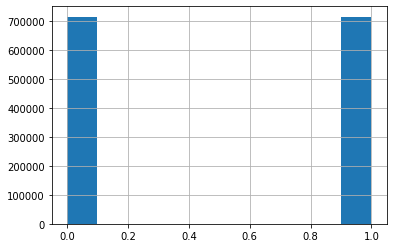

In [ ]:
train_df['HasDetections'].hist()

# Checking Duplicate Rows

In [ ]:
train_df.duplicated().sum()

0

# Checking for NULL values

In [ ]:
train_df.isna().sum()

Unnamed: 0                                                 0
MachineIdentifier                                          0
ProductName                                                0
EngineVersion                                              0
AppVersion                                                 0
AvSigVersion                                               0
IsBeta                                                     0
RtpStateBitfield                                        5157
IsSxsPassiveMode                                           0
DefaultBrowsersIdentifier                            1358403
AVProductStatesIdentifier                               5895
AVProductsInstalled                                     5895
AVProductsEnabled                                       5895
HasTpm                                                     0
CountryIdentifier                                          0
CityIdentifier                                         51877
OrganizationIdentifier  

In [ ]:
train_df.shape

(1427437, 84)

## Removing columns with NULL value > 500000 of the data in the training data set

In [ ]:
list_of_high_null_value_columns = []

In [ ]:
for col in train_df.columns:
  if(train_df[col].isna().sum() > 500000):
    list_of_high_null_value_columns.append(col);

Histograms for columns having high missing values

{'DefaultBrowsersIdentifier': 1358403,
 'PuaMode': 1427109,
 'SmartScreen': 508245,
 'Census_ProcessorClass': 1421703,
 'Census_InternalBatteryType': 1014565,
 'Census_IsFlightingInternal': 1185858,
 'Census_ThresholdOptIn': 907511,
 'Census_IsWIMBootEnabled': 906225}

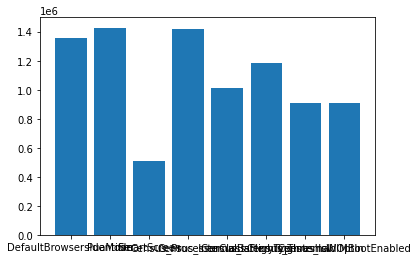

In [ ]:
nulls = {}
for col in list_of_high_null_value_columns:
    nulls[col] = train_df[col].isna().sum() 
# plt.bar(nulls.values(), nulls.keys(),color = 'g')
plt.bar(nulls.keys(), nulls.values())

nulls

In [ ]:
train_df.drop(axis="columns", labels=list_of_high_null_value_columns, inplace=True) 
test_df.drop(axis="columns", labels=list_of_high_null_value_columns, inplace=True) 

In [ ]:
train_df.shape

(1427437, 76)

In [ ]:
train_df.drop(labels = 'MachineIdentifier',axis = 'columns',inplace = True)

In [ ]:
train_df.dtypes

Unnamed: 0                                             int64
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
LocaleEnglishNameIdentif

In [ ]:
sel_obj_cols = list(train_df.select_dtypes(include='object'))
# for col in sel_obj_cols :
#   print(col + ": Null values count : "+ str(train_df[col].isna().sum()) + " Unique count : " + str(len(train_df[col].unique())))

# Filling Missing Values


Filling missing values of data type : object with mode()

In [ ]:
for col in sel_obj_cols:
  train_df[col].fillna(train_df[col].mode().iloc[0], inplace = True)
  test_df[col].fillna(test_df[col].mode().iloc[0], inplace = True)


In [ ]:
test_df.isna().sum()

Unnamed: 0                                                0
MachineIdentifier                                         0
ProductName                                               0
EngineVersion                                             0
AppVersion                                                0
AvSigVersion                                              0
IsBeta                                                    0
RtpStateBitfield                                       1286
IsSxsPassiveMode                                          0
AVProductStatesIdentifier                              1456
AVProductsInstalled                                    1456
AVProductsEnabled                                      1456
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                        13049
OrganizationIdentifier                               110418
GeoNameIdentifier                       

Checking Null value count

In [ ]:
sel_number_cols = list(train_df.select_dtypes(include='number'))

for col in sel_number_cols:
  train_df[col].fillna(train_df[col].mean(),inplace = True)
  if(col != 'HasDetections'):
    test_df[col].fillna(test_df[col].mean(),inplace = True)

# Label Encoding 

In [ ]:
label_encoder = LabelEncoder()

for col in sel_obj_cols:
  train_df[col] = label_encoder.fit_transform(train_df[col])
  test_df[col] = label_encoder.fit_transform(test_df[col])
  

# Removing Outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


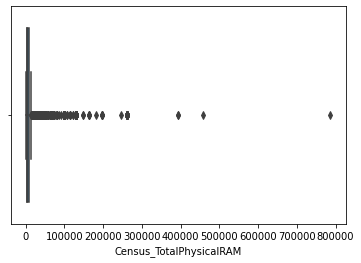

In [ ]:
sns.boxplot(train_df['Census_TotalPhysicalRAM'])

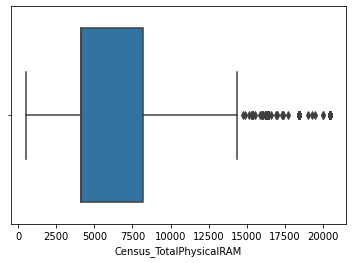

In [ ]:
ram = train_df['Census_TotalPhysicalRAM'].copy()
mean_ram = ram.mean()
std_ram = ram.std()
z_score_ram = (ram - mean_ram)/std_ram
filtered_entries_ram = (np.abs(z_score_ram) <= 3)
# print(filtered_entries_ram)
ram = ram[filtered_entries_ram]
sns.boxplot(x = ram)

In [ ]:
means = train_df.mean()
standard_deviation = train_df.std()
z_scores = (train_df - means)/standard_deviation
good = (np.abs(z_scores) <= 3)
filtered_entries = (np.abs(z_scores) <= 3).all(axis=1)




In [ ]:
# train_df = train_df[filtered_entries]

Handling outliers by bringing them into Inter Quartile Range(IQR)


IQR describes the middle 50% of values when ordered from lowest to highest 

In [ ]:

for column in train_df.columns:
    train_df.loc[z_scores[column] > 3, column] = means[column] + 3*standard_deviation[column]
    train_df.loc[z_scores[column] < -3, column] = means[column] - 3*standard_deviation[column]
    if(col!= 'HasDetections'):
      test_df.loc[z_scores[column] < -3, column] = means[column] - 3*standard_deviation[column]
      test_df.loc[z_scores[column] > 3, column] = means[column] + 3*standard_deviation[column]


###Heatmap to check the correlation

In [ ]:
sns.heatmap(train_df.corr(), annot=True)
# train_df.dtypes

##Fitting logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(max_iter= 1000)
x_train = train_df.copy()
x_train.drop(inplace = True,labels = ['HasDetections'], axis = 'columns')
y_train = train_df['HasDetections'].copy().astype('int64')


In [ ]:
y_train = y_train.astype('int16')
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
gc.collect()

3006

In [ ]:
y_pred = model.predict(x_train)
print("F1 score " + str(f1_score(y_train, y_pred)*100))
print("Accuracy score :" + str(accuracy_score(y_train,y_pred)*100))


F1 score 62.113446655900674
Accuracy score :59.50294128567496


In [ ]:
gc.collect()

44

In [ ]:
test_df.columns


Index(['AVProductStatesIdentifier', 'AVProductsEnabled', 'AVProductsInstalled',
       'AppVersion', 'AutoSampleOptIn', 'AvSigVersion',
       'Census_ActivationChannel', 'Census_ChassisTypeName',
       'Census_DeviceFamily', 'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier', 'Census_FlightRing',
       'Census_GenuineStateName', 'Census_HasOpticalDiskDrive',
       'Census_InternalBatteryNumberOfCharges',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalPrimaryDisplayResolutionVertical',
       'Census_IsAlwaysOnAlwaysConnectedCapable', 'Census_IsFlightsDisabled',
       'Census_IsPenCapable', 'Census_IsPortableOperatingSystem',
       'Census_IsSecureBootEnabled', 'Census_IsTouchEnabled',
       'Census_IsVirtualDevice', 'Census_MDC2FormFactor',
       'Census_OEMModelIdentifier', 'Census_OEMNameIdentifier',
       'Census_OSArchitecture', 'Census_OSBranch',

In [ ]:
submission = pd.DataFrame({"Id":test_df['MachineIdentifier']})

# print(x_train.columns)
# print(test_df.columns))

In [ ]:
test_df.drop(inplace=True , labels = 'HasDetections',axis = 1)


In [ ]:
test_df.drop(inplace=True , labels = 'MachineIdentifier',axis = 1)


In [ ]:
predictions = model.predict(test_df)
submission["Expected"] = predictions

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
submission.to_csv("sample_submission.csv", index=False)

# Pricipal Component Analysis (PCA)

In [ ]:
gc.collect()

22

In [ ]:
from sklearn.decomposition import PCA

# Assuming 10 components
pca = PCA(n_components=10)
df3 = pd.DataFrame(pca.fit_transform(x_train))
test_df = pd.DataFrame(pca.transform(test_df))
x_pca_train,x_pca_test,y_pca_train,y_pca_test = train_test_split(df3,y_train, test_size=0.2,random_state=0)
model.fit(x_pca_train,y_pca_train)
print(model.score(x_pca_test,y_pca_test)*100)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


56.742840329540996


In [ ]:
print(test_df.columns)
# test_df = pd.DataFrame(pca.transform(test_df))
y_test = model.predict(test_df)

RangeIndex(start=0, stop=10, step=1)


In [ ]:
submission["Expected"] = y_test

In [ ]:
submission.to_csv("sample_submission_2.csv", index=False)

In [ ]:
print(model.score(x_pca_train,y_pca_train)*100)

56.95525807194542


In [ ]:
gc.collect()

44